In [ ]:
from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite
import matplotlib.pyplot as plt

In [ ]:
def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element.notes:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)
    print(f"{[instrument_i.recurse() for instrument_i in instruments.parts]}")

    data = {}

    output = []

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                output.append(matrix.astype(np.uint8))
                index += 1
            else:
                break
    return output

In [ ]:
img = midi2image("/content/drive/MyDrive/CS236/CS236 Final Project/chor_371.mid")

[<music21.stream.iterator.RecursiveIterator for Part:None @:0>]


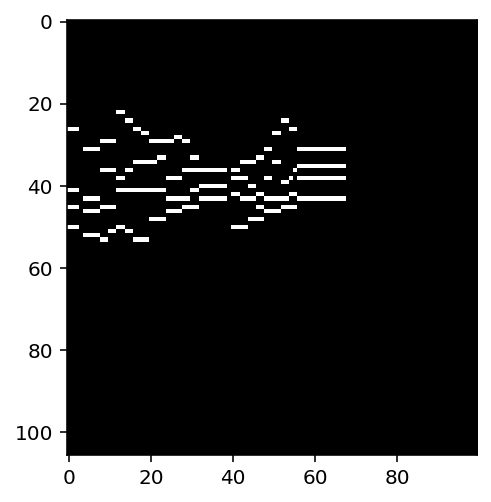

In [ ]:
plt.imshow(img[2],cmap='gray')